In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras 
import warnings

warnings.filterwarnings('ignore')
print(tf.__version__)
for model in sklearn, pd, keras, np ,mlp:
    print(model.__name__, model.__version__)

2.1.0
sklearn 0.20.2
pandas 0.24.2
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf
numpy 1.17.4
matplotlib 2.1.2


In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
housing = fetch_california_housing()
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=2)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [3]:
# version 0.2 数据归一化
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
x_train = std.fit_transform(x_train)
x_valid = std.transform(x_valid)
x_test = std.transform(x_test)
print(x_train.shape[1:])

(8,)


In [4]:
"""
# 函数式 API
input = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)

# 假设 wide部分 和deep 部分的输入是一样的，因此需要将数据进行合并
concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

# 将写好的网络结构固化下来
model = keras.models.Model(inputs=[input],
                           outputs=[output])
"""

# 多输入，函数式 API
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide,hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input_wide, input_deep],
                           outputs = [output])




# sparse_categorical_crossentropy:  如果y是一个数，会把它转化成一个向量，如 y->index., y->one hot->[]
model.compile(loss='mean_squared_error',
              optimizer='adam')


In [5]:
# version 0.3 回调函数
# Tensorboard, Earlystopping, Modelcheckpoint
logdir = './wide_deep_callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "housing_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [7]:
"""
# 单输入训练
history = model.fit(x_train, y_train, epochs=10,validation_data=(x_valid, y_valid),callbacks=callbacks)
"""

# 多输入训练
x_train_wide = x_train[:, :5]
x_train_deep = x_train[:, 2:]
x_valid_wide = x_valid[:, :5]
x_valid_deep = x_valid[:, 2:]
x_test_wide = x_test[:, :5]
x_test_deep = x_test[:, 2:]
history = model.fit([x_train_wide, x_train_deep],
                    y_train,
                    epochs=10,
                    validation_data=([x_valid_wide, x_valid_deep],
                                     y_valid),
                    callbacks=callbacks)


Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 72us/sample - loss: 1.8012 - val_loss: 0.8125
Epoch 2/10
11610/11610 [==============================] - 1s 55us/sample - loss: 0.6837 - val_loss: 0.5977
Epoch 3/10
11610/11610 [==============================] - 1s 44us/sample - loss: 0.5389 - val_loss: 0.4838
Epoch 4/10
11610/11610 [==============================] - 0s 43us/sample - loss: 0.4640 - val_loss: 0.4283
Epoch 5/10
11610/11610 [==============================] - 1s 68us/sample - loss: 0.4187 - val_loss: 0.3859
Epoch 6/10
11610/11610 [==============================] - 1s 47us/sample - loss: 0.3822 - val_loss: 0.3638
Epoch 7/10
11610/11610 [==============================] - 1s 43us/sample - loss: 0.3692 - val_loss: 0.3471
Epoch 8/10
11610/11610 [==============================] - 1s 43us/sample - loss: 0.3556 - val_loss: 0.3402
Epoch 9/10
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3437 - val_l

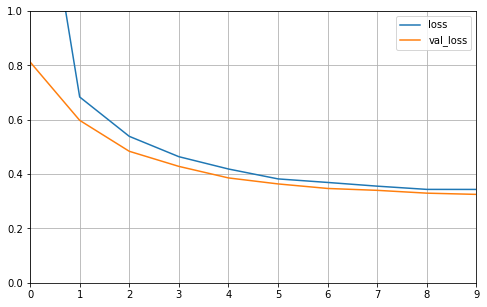

In [8]:
def plot_learning_curve(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curve(history)

In [9]:
model.evaluate([x_test_wide, x_test_deep],
               y_test)

5160/5160 [==============================] - 0s 20us/sample - loss: 0.3615


0.36152127976565396

In [10]:
model.predict([x_test_wide, x_test_deep])

array([[3.1777182 ],
       [0.6539929 ],
       [2.0863278 ],
       ...,
       [0.26417467],
       [2.7958446 ],
       [1.217457  ]], dtype=float32)